# Generative Path Planning

In this notebook, we explore the exetnt to which generative models can solve path planning problems. We experiment with various architectures and compare their competency in conditional and unconditional path generation.

## 1. Background

### 1.1. Path Planning

Given a weighted graph $G = (V, E)$ with vertices $v, w \in V$, we wish to find an optimal path from $v$ to $w$ such that the total weight is minimized.

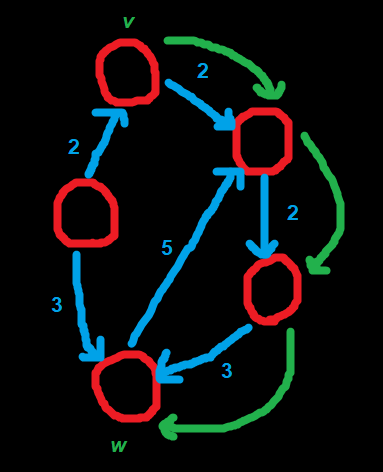

Figure 1. A weighted graph with the optimal path from $v$ to $w$ shown in green.

Several algorithms exist for optimally solving path planning problems in polytimal time. One such algorithm is A*, which finds optimal solutions in only $O(|E|)$ time.

### 1.2. Generative Models

A generative model is a statistical model of the joint distribution over a set of random variables. Examples include hidden Markov models, autoencoders and generative adversarial networks (GANs).

## 2. Data

In this section, we create a path planning dataset, consisting of board-based path planning problems and their corresponding solutions found using A*. We represent board configurations as binary images with separate channels for obstacles, source/destination cells, and A*-visited cells.

In [1]:
!pip install astar

In [2]:
from typing import Any, List, Tuple

import random
import numpy as np
import astar

In [3]:
def create_channel_from_cells(
    cells: List[Tuple[int, int]], 
    shape: Tuple[int, int]
) -> np.array:
    
    channel = np.zeros(shape)
    
    for cell in cells:
        channel[cell] = 1.
    
    return channel

In [4]:
def solve_a_star(
    source_cell: Tuple[int, int], 
    destination_cell: Tuple[int, int],
    obstacle_cells: List[Tuple[int, int]],
    board_shape: Tuple[int, int],
) -> List:
    
    def is_bounded(y, x):
        return (y >= 0 and y < board_shape[0]) and (x >= 0 and x < board_shape[1])
    
    def neighbors_function(cell):
        
        y, x = cell
        
        neighbors = [
            (y - 1, x),
            (y, x + 1),
            (y + 1, x),
            (y, x - 1),
        ]
        
        return [(y, x) for y, x in neighbors if (y, x) not in obstacle_cells and is_bounded(y, x)]
    
    return astar.find_path(
        start = source_cell,
        goal = destination_cell,
        neighbors_fnct = neighbors_function,
        reversePath=False,
        heuristic_cost_estimate_fnct = lambda a, b: float('inf'),
        distance_between_fnct = lambda a, b: 1.0,
        is_goal_reached_fnct = lambda a, b: a == b
    )

In [5]:
def create_dataset(
    number_of_obstacles: int = 10,
    number_of_boards: int = 10,
    board_shape: Tuple[int, int] = (5, 5),
) -> np.array:
    
    cells = [(y, x) for x in range(board_shape[1]) for y in range(board_shape[0])]
    dataset = []
    
    for i in range(number_of_boards):
        
        cells_sample = random.sample(cells, k = number_of_obstacles + 3)
        
        source_cells = cells_sample[0 : 1]
        destination_cells = cells_sample[1 : 2]
        obstacle_cells = cells_sample[2 :]
        
        try:
            solution_cells = list(solve_a_star(
                source_cells[0], 
                destination_cells[0], 
                obstacle_cells,
                board_shape
            ))
        except:
            continue
        
        dataset.append(np.array([
            create_channel_from_cells(source_cells, board_shape),
            create_channel_from_cells(destination_cells, board_shape),
            create_channel_from_cells(obstacle_cells, board_shape),
            create_channel_from_cells(solution_cells, board_shape),
        ]))
    
    return dataset

In [6]:
create_dataset()

[array([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]],
 
        [[0., 1., 1., 1., 1.],
         [1., 0., 1., 1., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0.]],
 
        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]]),
 array([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.]],
 
        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0.],
         [1., 1., 1.,

## 3. Modelling

We now turn to the task of modelling the joint distribution over our dataset. The first architecture we experiment with is a conditional variational autoencoder (CVAE). A traditional variational autoencoder assumes examples can be described in terms of several latent variables, each having a Gaussian prior $\mathcal{N}(0, 1)$. When an example is fed in, the encoder network infers a posterior distribution over the latent variables and samples from it to produce a latent code. The decoder network then attempts to reconstruct the original example from the latent code. After jointly training both networks against an MLE objective, the decoder can be used as a generative model through marginalization.

$$p(x) = \int_z p(x, z) = \int_z p(z) p(x|z)$$

In a CVAE, the encoder and decoder networks are conditioned on a label $y$. In our case, $y$ will be a particular board configuration. The hope is that our CVAE will learn to mimic A* solutions to arbitrary board-based path planning problems.

First we implement a CVAE for MNIST to familiarise ourselves with the architecture.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Activation,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Input,
    Flatten,
    Reshape,
    ReLU,
    Lambda,
    LeakyReLU,
)

2022-11-29 19:24:41.630209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 19:24:42.416889: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 19:24:42.416921: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-29 19:24:44.582723: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

### Preliminary 1

In [138]:
# MNIST convolutional autoencoder

input_shape = (28, 28, 1)
latent_dimension = 2

encoder_input = Input(shape=input_shape)
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = Flatten()(x)
encoder_output = Dense(latent_dimension)(x)

encoder = tf.keras.Model(encoder_input, encoder_output)


decoder_input = Input(shape=(latent_dimension,))
x = Dense(7 * 7 * 64)(decoder_input)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')(x)
decoder_output = Activation('sigmoid')(x)

decoder = tf.keras.Model(decoder_input, decoder_output)

autoencoder = tf.keras.Model(encoder_input, decoder(encoder_output))

In [139]:
autoencoder.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_83 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_70 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_71 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_85 (LeakyReLU)  (None, 7, 7, 64)          0  

In [156]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

loss_function = lambda y, yp: tf.keras.backend.mean(tf.keras.backend.square(y - yp), axis=[1,2,])

autoencoder.compile(optimizer=optimizer, loss=loss_function)

In [7]:
train, test = tf.keras.datasets.mnist.load_data()
x_train, y_train = train
x_test, y_test = test
x_train = x_train.astype('float') / 255

In [160]:
autoencoder.fit(
    x = x_train,
    y = x_train,
    batch_size=128,
    shuffle=True,
    epochs=10,
)

Epoch 1/10
469/469 [==============================] - 71s 148ms/step - loss: 0.0615
Epoch 2/10
469/469 [==============================] - 85s 180ms/step - loss: 0.0485
Epoch 3/10
469/469 [==============================] - 84s 179ms/step - loss: 0.0456
Epoch 4/10
469/469 [==============================] - 75s 160ms/step - loss: 0.0441
Epoch 5/10
469/469 [==============================] - 76s 163ms/step - loss: 0.0432
Epoch 6/10
469/469 [==============================] - 77s 165ms/step - loss: 0.0424
Epoch 7/10
469/469 [==============================] - 74s 159ms/step - loss: 0.0419
Epoch 8/10
 80/469 [====>.........................] - ETA: 1:03 - loss: 0.0415

KeyboardInterrupt: 

In [199]:
a = autoencoder.predict(x_train[3].reshape((1, 28, 28, 1))).reshape((28, 28))

1/1 [==============================] - 0s 23ms/step


In [10]:
from PIL import Image

In [201]:
Image.fromarray((a * 255).round().astype('uint8'), 'L')

In [202]:
Image.fromarray((x_train[3] * 255).round().astype('uint8'), 'L')

### Preliminary 2

In [236]:
# Convolutional VAE

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Encoder

# Sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# Full model

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_109 (Conv2D)            (None, 14, 14, 32)   320         ['input_54[0][0]']               
                                                                                                  
 conv2d_110 (Conv2D)            (None, 7, 7, 64)     18496       ['conv2d_109[0][0]']             
                                                                                                  
 flatten_27 (Flatten)           (None, 3136)         0           ['conv2d_110[0][0]']             
                                                                                            

In [237]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 38s 67ms/step - loss: 261.1054 - reconstruction_loss: 212.0967 - kl_loss: 2.5226
Epoch 2/30
547/547 [==============================] - 39s 71ms/step - loss: 180.2571 - reconstruction_loss: 169.9034 - kl_loss: 5.5958
Epoch 3/30
547/547 [==============================] - 44s 81ms/step - loss: 167.5663 - reconstruction_loss: 160.2836 - kl_loss: 5.7888
Epoch 4/30
547/547 [==============================] - 47s 86ms/step - loss: 162.4241 - reconstruction_loss: 155.9568 - kl_loss: 6.0483
Epoch 5/30
547/547 [==============================] - 46s 84ms/step - loss: 160.5182 - reconstruction_loss: 153.6934 - kl_loss: 6.1982
Epoch 6/30
547/547 [==============================] - 44s 81ms/step - loss: 158.5034 - reconstruction_loss: 152.0222 - kl_loss: 6.3034
Epoch 7/30
547/547 [==============================] - 46s 84ms/step - loss: 157.1240 - reconstruction_loss: 150.8310 - kl_loss: 6.3646
Epoch 8/30
547/547 [==============================] - 4

KeyboardInterrupt: 

1875/1875 [==============================] - 6s 3ms/step


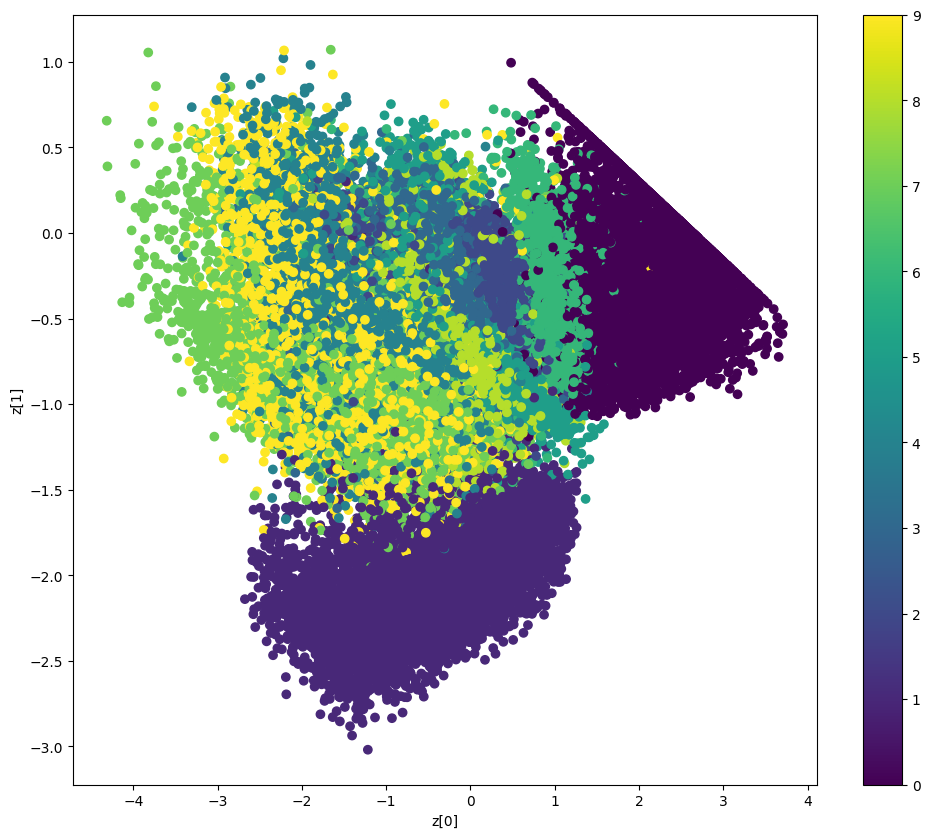

In [256]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

In [294]:
a1=decoder.predict([ [-1, -2.4] ]).reshape((28, 28))
Image.fromarray((a1 * 255).astype('uint8') , 'L')

1/1 [==============================] - 0s 57ms/step


### Preliminary 3

In [92]:
# Conditional Variational Autoencoder (non-convolutional) (bi-level output) (implemented in PyTorch)

from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


class CVAE(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.input_size = 28 * 28
        self.label_size = 10
        self.embed_size = 2
        
        self.encoder = nn.Sequential(
            nn.Linear(self.input_size + self.label_size, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.embed_size + self.label_size, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, self.input_size),
            nn.Sigmoid(),
        )
        
        self.embed_mean = nn.Linear(32, self.embed_size)
        self.embed_log_variance = nn.Linear(32, self.embed_size)
        
        
    def forward(self, input, label):
        
        input = input.view(-1, self.input_size) # flatten input
        label = F.one_hot(label, num_classes=10)        
        
        x = torch.cat((input, label), dim=-1) # Concatenate the input and conditional label.
        x = self.encoder(x)
        z_mean = self.embed_mean(x)
        z_log_variance = self.embed_log_variance(x)
        z = z_mean
        
        # Sample from the posterior when training...
        
        if self.training:
            epsilon = torch.randn_like(z_mean)
            z = z_mean + torch.exp(z_log_variance * 0.5) * epsilon

        x = torch.cat((z, label), dim=-1) # Concatenate the latent code and conditional label.
        reconstruction = self.decoder(x).view(-1, 1, 28, 28)
        
        if self.training:
            return (reconstruction, z_mean, z_log_variance)
        
        return reconstruction
    

# Loss function 

def cvae_loss(input, reconstruction, z_mean, z_log_variance):

    # Reconstruction error

    reconstruction_loss = F.binary_cross_entropy(reconstruction, input, reduction='sum')
    kl_loss = -0.5 * (1 + z_log_variance - z_mean ** 2 - z_log_variance.exp()).sum()

    return reconstruction_loss + kl_loss
        
        


In [95]:
dataset = torchvision.datasets.MNIST(root="data-mnist", download=True, transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST(root="data-mnist", train=False, transform=torchvision.transforms.ToTensor())

loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1)

In [98]:
autoencoder_4 = CVAE()
loss_fn = cvae_loss
optimizer = torch.optim.Adam(autoencoder_4.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    
    for b, (input, label) in enumerate(loader):
        
        optimizer.zero_grad()
        reconstruction, z_mean, z_log_variance = autoencoder_4(input, label)
        
        loss = loss_fn(input, reconstruction, z_mean, z_log_variance)
        loss.backward()
        optimizer.step()
        
        if (b % 160) == 0:

            print("Epoch {}: Batch [{}/{}] Loss: {}".format(
                epoch,
                b + 1,
                len(loader),
                loss.item() / input.size(0)
            ))

Epoch 0: Batch [1/469] Loss: 544.67236328125
Epoch 0: Batch [161/469] Loss: 186.2825164794922
Epoch 0: Batch [321/469] Loss: 170.53646850585938
Epoch 1: Batch [1/469] Loss: 153.15341186523438
Epoch 1: Batch [161/469] Loss: 148.72894287109375
Epoch 1: Batch [321/469] Loss: 147.57192993164062
Epoch 2: Batch [1/469] Loss: 153.78736877441406
Epoch 2: Batch [161/469] Loss: 141.806640625
Epoch 2: Batch [321/469] Loss: 144.04757690429688
Epoch 3: Batch [1/469] Loss: 136.42384338378906
Epoch 3: Batch [161/469] Loss: 142.17938232421875
Epoch 3: Batch [321/469] Loss: 145.97178649902344
Epoch 4: Batch [1/469] Loss: 130.35794067382812
Epoch 4: Batch [161/469] Loss: 139.47962951660156
Epoch 4: Batch [321/469] Loss: 130.4752197265625
Epoch 5: Batch [1/469] Loss: 130.25009155273438
Epoch 5: Batch [161/469] Loss: 128.42919921875
Epoch 5: Batch [321/469] Loss: 133.61529541015625
Epoch 6: Batch [1/469] Loss: 134.86444091796875
Epoch 6: Batch [161/469] Loss: 132.9448699951172
Epoch 6: Batch [321/469] Los

In [464]:
def render_example(array):
    
    return Image.fromarray((array * 255).numpy().astype('uint8'))

render_example(dataset[2][0][0])

NameError: name 'Image' is not defined

In [149]:
def render_reconstruction(input, label):
    
    reconstruction, z_mean, z_log_variance = autoencoder_4(input, label)
    
    reconstruction = reconstruction.detach().numpy()
    reconstruction = (reconstruction * 255).astype('uint8')
    reconstruction = reconstruction.reshape((28, 28))
    
    return Image.fromarray(reconstruction), z_mean, z_log_variance

In [153]:
render_reconstruction(dataset[2][0], torch.tensor([ dataset[2][1] ]))

(<PIL.Image.Image image mode=L size=28x28>,
 tensor([[-0.7901, -0.1261]], grad_fn=<AddmmBackward0>),
 tensor([[-0.8368, -0.1319]], grad_fn=<AddmmBackward0>))

In [158]:
def render_decoding(z, label):
    
    label = F.one_hot(torch.tensor([ label ]), num_classes=10) 
    
    x = torch.cat((z, label), dim=-1) # Concatenate the latent code and conditional label.
    reconstruction = autoencoder_4.decoder(x).view(-1, 1, 28, 28)
    reconstruction = reconstruction.detach().numpy()
    reconstruction = (reconstruction * 255).astype('uint8')
    reconstruction = reconstruction.reshape((28, 28))
    
    return Image.fromarray(reconstruction)

In [188]:
# Upward pointing digits

render_decoding(torch.tensor([[0., 1.]]), 9)
render_decoding(torch.tensor([[0., 1.]]), 8)
render_decoding(torch.tensor([[0., 1.]]), 7)

In [189]:
# Slanted digits

render_decoding(torch.tensor([[0.7901, -0.1261]]), 1)
render_decoding(torch.tensor([[0.7901, -0.1261]]), 2)
render_decoding(torch.tensor([[0.7901, -0.1261]]), 4)
render_decoding(torch.tensor([[0.7901, -0.1261]]), 7)

In [231]:
# This seems to generate very coherent digits

render_decoding(torch.tensor([[1, 1.]]), 8)

In [245]:
# Very thin digits...

render_decoding(torch.tensor([[2, 2.]]), 2)
render_decoding(torch.tensor([[2, 2.]]), 3)

### 3.1. Conditional Autoencoder

In [9]:
board_dataset = create_dataset(number_of_boards=1200)

In [96]:
len(board_dataset)

654

In [97]:
# This would go in a functions.py file in the proper implementation

def sample_normal(
    mean: Tensor, 
    variance: Tensor,
) -> Tensor:
    """
    Samples from a multivariate normal distribution with given mean and 
    variance. Note that the parameters remain differentiable.
    """

    return torch.rand_like(mean) * torch.exp(variance * 0.5) + mean

In [437]:
from typing import Any, List, Tuple
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor as Tensor


#@dataclass
class AutoencoderForGenerativePathPlanning(nn.Module):
    """
    A conditional variational autoencoder for solving image-based 
    path planning problems.
    """
    

    
    
    def __init__(self):
        super().__init__()
        
        self.image_channels: int = 4
        self.image_features: int = 5 * 5
        self.embed_features: int = 5    
        
        # Architecture...
        
        self.encoder_layer_0_features = self.image_features * self.image_channels
        self.encoder_layer_1_features = self.encoder_layer_0_features // 2
        self.encoder_layer_2_features = self.encoder_layer_1_features // 2
        self.encoder_layer_3_features = self.embed_features
        self.decoder_layer_0_features = self.encoder_layer_0_features - self.image_features + self.embed_features
        self.decoder_layer_1_features = self.decoder_layer_0_features // 1
        self.decoder_layer_2_features = self.decoder_layer_1_features // 2
        self.decoder_layer_3_features = self.image_features
        
        
        # Initialization...
        
        self.encoder = nn.Sequential(
            nn.Linear(self.encoder_layer_0_features, self.encoder_layer_1_features),
            nn.ReLU(),
            nn.Linear(self.encoder_layer_1_features, self.encoder_layer_2_features),
            nn.ReLU(),
        )
        
        
        self.encoder_mean = nn.Linear(self.encoder_layer_2_features, self.encoder_layer_3_features)
        self.encoder_variance = nn.Linear(self.encoder_layer_2_features, self.encoder_layer_3_features)
        
        
        self.decoder = nn.Sequential(
            nn.Linear(self.decoder_layer_0_features, self.decoder_layer_1_features),
            nn.ReLU(),
            nn.Linear(self.decoder_layer_1_features, self.decoder_layer_2_features),
            nn.ReLU(),
            nn.Linear(self.decoder_layer_2_features, self.decoder_layer_3_features),
            nn.Sigmoid(),
        )
        
    
    def forward(self, x, y):
        """
        Performs forward propagation, returning a reconstructed image.
        """
        
        x = torch.cat((x, y), dim=-1)    
        x = self.encoder(x)

        z_mean = self.encoder_mean(x)
        z_variance = self.encoder_variance(x)
        z = z_mean
        
        if self.training:
            z += torch.rand_like(z_mean) * torch.exp(z_variance * 0.5)
            
        x = torch.cat((z, y), dim=-1)
        x = self.decoder(x)
        
        return x, z_mean, z_variance
        
        
        
    
#     def forward(
#         self, 
#         image: Tensor
#     ) -> Tensor:
#         """
        
#         """
        
#         # Flatten the image in order to concatenate all channels into a single
#         # vector.
        
#         x = image.flatten(start_dim=1) 
#         x = self.encoder(x)
#         z_mean = self.embed_mean(x)
#         z_log_variance = self.embed_log_variance(x)
#         z = z_mean
        
#         # Sample from the posterior when training...
        
#         if self.training:
#             epsilon = torch.randn_like(z_mean)
#             z = z_mean + torch.exp(z_log_variance * 0.5)

#         x = torch.cat((z, label), dim=-1) # Concatenate the latent code and conditional label.
#         reconstruction = self.decoder(x).view(-1, 1, 28, 28)
        
#         if self.training:
#             return (reconstruction, z_mean, z_log_variance)
        
#         return reconstruction
        
            

In [256]:
p = create_dataset(number_of_boards=3)
p = torch.tensor(p).float()
len(p)

2

In [250]:
a= AutoencoderForGenerativePathPlanning()
a

AutoencoderForGenerativePathPlanning(image_channels=4, image_features=25, embed_features=5)

In [259]:
def preprocess_dataset(dataset):
    
    labels = dataset[:,1 :].flatten(1)
    inputs = dataset[:,-1].flatten(1)
    
    return inputs, labels

In [260]:
x, y = preprocess_dataset(p)
x

tensor([[0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]])

In [350]:
def cvae_loss(image, reconstruction, z_mean, z_log_variance):

    # Reconstruction error

    reconstruction_loss = F.binary_cross_entropy(reconstruction, image, reduction='sum')
    kl_loss = -0.5 * (1 + z_log_variance - z_mean ** 2 - z_log_variance.exp()).sum()
    return reconstruction_loss + kl_loss
        

In [358]:
dataset_orig = create_dataset(number_of_boards=15_000)
dataset_orig = torch.tensor(dataset_orig).float()
dataset = preprocess_dataset(dataset_orig)
dataset = [(x, y) for x, y in zip(dataset[0], dataset[1])]

print(len(dataset_orig))

loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

8453


In [352]:


# autoencoder_5 = AutoencoderForGenerativePathPlanning()
# c = enumerate(loader)
# a, (x, y) = next(c)

In [371]:

#autoencoder_5 = AutoencoderForGenerativePathPlanning()
loss_fn = cvae_loss
optimizer = torch.optim.Adam(autoencoder_5.parameters(), lr=1e-3)
epochs = 20

for epoch in range(epochs):
    
    for b, (input, label) in enumerate(loader):
        
        optimizer.zero_grad()
        reconstruction, z_mean, z_log_variance = autoencoder_5(input, label)
        
        loss = loss_fn(input, reconstruction, z_mean, z_log_variance)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 5 == 0:
        print("Epoch {}: Batch [{}/{}] Loss: {}".format(
            epoch,
            b + 1,
            len(loader),
            loss.item() / input.size(0)
        ))

Epoch 4: Batch [67/67] Loss: 0.2270293951034546
Epoch 9: Batch [67/67] Loss: 0.20669941902160643
Epoch 14: Batch [67/67] Loss: 0.24960453510284425
Epoch 19: Batch [67/67] Loss: 0.18262549638748168


In [375]:
def render_reconstruction(image, label):
    r, mean, var = autoencoder_5.forward(image, label)
    
    r = r.view(-1, 1, 5, 5)
    return r, mean, var

In [384]:
def render_decoding(embedding, label):
    
    x = torch.cat((embedding, label), dim=-1)
    x = autoencoder_5.decoder(x)
    
    r = x.view(-1, 1, 5, 5)
    return r

In [380]:
render_reconstruction(dataset[0][0], dataset[0][1])

(tensor([[[[4.0429e-15, 2.8464e-08, 1.7451e-11, 8.1200e-12, 2.2203e-09],
           [2.6179e-13, 9.0924e-11, 8.2154e-12, 5.1569e-08, 2.0884e-17],
           [1.0477e-12, 1.3691e-13, 5.5685e-11, 1.0000e+00, 8.1342e-08],
           [3.4425e-12, 4.5099e-11, 1.5290e-08, 1.0000e+00, 1.0000e+00],
           [3.0293e-09, 8.5607e-12, 5.6518e-15, 8.6594e-07, 1.0000e+00]]]],
        grad_fn=<ViewBackward0>),
 tensor([ 0.0868,  0.1591, -0.3786, -0.1571,  0.0855], grad_fn=<AddBackward0>),
 tensor([-0.0861, -0.0792, -0.0895, -0.0849, -0.0723], grad_fn=<AddBackward0>))

In [392]:
render_decoding(torch.tensor([0, 0, 0, 0, 0]), dataset[1][1]).round()

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1.]]]], grad_fn=<RoundBackward0>)

In [439]:
dataset_orig[1]

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1.]],

        [[1., 0., 0., 1., 0.],
         [0., 1., 1., 1., 0.],
         [1., 1., 0., 0., 1.],
         [1., 0., 1., 0., 1.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1.]]])

In [427]:
test_dataset = create_dataset(number_of_boards=100)

In [428]:
test_dataset_pp = preprocess_dataset(torch.tensor(test_dataset).float())


In [429]:
test_images, test_labels = test_dataset_pp

In [430]:
test_dataset[0][-1]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [435]:
test_images[10].view(-1, 1, 5, 5)

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 1., 1., 0., 0.]]]])

In [438]:
render_decoding(torch.tensor([0, 0, 0, 0, 0]), test_labels[10]).round()

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 1., 1., 0., 0.]]]], grad_fn=<RoundBackward0>)

Successful mimicry!  
Edit: nah it just overfit (badly)

In [461]:
l = torch.tensor([
    [[0, 0, 0, 0, 1], # start
     [0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0]],

    [[0, 0, 1, 0, 0], # end
     [0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0], # obstacles
     [1, 0, 0, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 1, 1, 0, 0],
     [0, 1, 0, 0, 0]],    
]).float().flatten()

In [463]:
render_decoding(torch.tensor([0, 0, 0, 0, 0]), l).round()

tensor([[[[0., 0., 0., 0., 0.],
          [1., 0., 1., 0., 0.],
          [0., 0., 1., 1., 1.],
          [0., 1., 1., 0., 0.],
          [0., 1., 1., 0., 0.]]]], grad_fn=<RoundBackward0>)

In [451]:
test_labels[10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0.])

In [452]:
l.shape

torch.Size([75])